In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from keras import regularizers
import tensorflow as tf 

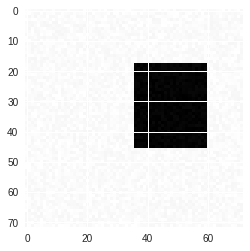

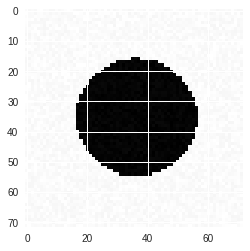

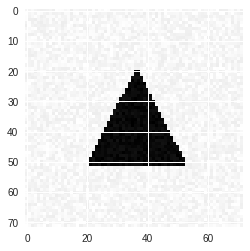

In [325]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




In [326]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train,num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


# Simple Classification

We would like to classify a picture within the three classes: Circle, rectangle and triangle. To do so, we first try a linear classifier. First we try to Stochastic Gradient Descent.

In [327]:
model = Sequential()
model.add(Dense(3,input_dim=IMAGE_SIZE**2,activation = 'softmax'))

sgd = SGD(lr=0.001,decay=1e-6, momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=32)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(model.predict(X_test))

Epoch 1/10
300/300 [==============================] - 4s 15ms/step - loss: 1.3308 - acc: 0.4133
Epoch 2/10
300/300 [==============================] - 0s 154us/step - loss: 0.5985 - acc: 0.7433
Epoch 3/10
300/300 [==============================] - 0s 149us/step - loss: 0.4181 - acc: 0.8800
Epoch 4/10
300/300 [==============================] - 0s 148us/step - loss: 0.3355 - acc: 0.9233
Epoch 5/10
300/300 [==============================] - 0s 168us/step - loss: 0.3076 - acc: 0.8833
Epoch 6/10
300/300 [==============================] - 0s 172us/step - loss: 0.2719 - acc: 0.9400
Epoch 7/10
300/300 [==============================] - 0s 169us/step - loss: 0.2219 - acc: 0.9600
Epoch 8/10
300/300 [==============================] - 0s 167us/step - loss: 0.2183 - acc: 0.9533
Epoch 9/10
300/300 [==============================] - 0s 161us/step - loss: 0.2041 - acc: 0.9600
Epoch 10/10
300/300 [==============================] - 0s 175us/step - loss: 0.1784 - acc: 0.9667
[[0. 1. 0.]]


Then we use the Adam optimizer. We obtain quite similar performances.

In [328]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=32)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(model.predict(X_test))

Epoch 1/10
300/300 [==============================] - 4s 14ms/step - loss: 0.6176 - acc: 0.8067
Epoch 2/10
300/300 [==============================] - 0s 147us/step - loss: 0.3529 - acc: 0.8367
Epoch 3/10
300/300 [==============================] - 0s 145us/step - loss: 0.1681 - acc: 0.9633
Epoch 4/10
300/300 [==============================] - 0s 144us/step - loss: 0.1229 - acc: 0.9867
Epoch 5/10
300/300 [==============================] - 0s 143us/step - loss: 0.1139 - acc: 0.9767
Epoch 6/10
300/300 [==============================] - 0s 146us/step - loss: 0.1061 - acc: 0.9867
Epoch 7/10
300/300 [==============================] - 0s 150us/step - loss: 0.0873 - acc: 0.9967
Epoch 8/10
300/300 [==============================] - 0s 158us/step - loss: 0.0770 - acc: 0.9933
Epoch 9/10
300/300 [==============================] - 0s 157us/step - loss: 0.0719 - acc: 1.0000
Epoch 10/10
300/300 [==============================] - 0s 150us/step - loss: 0.0775 - acc: 1.0000
[[0. 1. 0.]]


# Visualization of the Solution

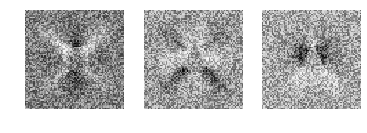

In [329]:
fig, axs = plt.subplots(1, 3)
for i in range(3):
    axs[i].axis('off')
    axs[i].imshow(model.get_weights()[0][:,i].reshape(IMAGE_SIZE,IMAGE_SIZE))

#A More Diffcult Classification Problem

Now the geometric shapes are allowed to be anywhere in the image and not necessarily centered. Therefore the task is more involved.

In [330]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
Y_train2 = np_utils.to_categorical(Y_train2,num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [331]:
[X_test2, Y_test2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [332]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

model.fit(X_train2, Y_train2, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 4s 15ms/step - loss: 3.6155 - acc: 0.2967
Epoch 2/10
300/300 [==============================] - 0s 157us/step - loss: 2.9943 - acc: 0.3000
Epoch 3/10
300/300 [==============================] - 0s 156us/step - loss: 2.1148 - acc: 0.3800
Epoch 4/10
300/300 [==============================] - 0s 147us/step - loss: 2.0146 - acc: 0.3700
Epoch 5/10
300/300 [==============================] - 0s 167us/step - loss: 1.6863 - acc: 0.4033
Epoch 6/10
300/300 [==============================] - 0s 161us/step - loss: 1.5094 - acc: 0.4033
Epoch 7/10
300/300 [==============================] - 0s 154us/step - loss: 1.3051 - acc: 0.4767
Epoch 8/10
300/300 [==============================] - 0s 175us/step - loss: 1.3858 - acc: 0.4733
Epoch 9/10
300/300 [==============================] - 0s 155us/step - loss: 1.0673 - acc: 0.5100
Epoch 10/10
300/300 [==============================] - 0s 162us/step - loss: 1.1846 - acc: 0.4967


We find a lower accuracy than before with this new problem when we still use a linear classifier.

In [333]:
eval = model.evaluate(X_test2, Y_test2)
for i in range(2):
    print('{} : {}'.format(model.metrics_names[i],eval[i]))

300/300 [==============================] - 2s 6ms/step
loss : 1.1342944208780925
acc : 0.45666666666666667


We want to try a more complex model, with a convolutional filter.

In [421]:
Xtrain2 = X_train2.reshape(X_train2.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

model.fit(Xtrain2, Y_train2, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 8s 25ms/step - loss: 1.3643 - acc: 0.3700
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 1.0121 - acc: 0.5467
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.8494 - acc: 0.6467
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.7333 - acc: 0.7833
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.6572 - acc: 0.7900
Epoch 6/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5767 - acc: 0.8067
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5469 - acc: 0.7933
Epoch 8/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4932 - acc: 0.8600
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4663 - acc: 0.8400
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4154 - acc: 0.9000
Epoch 11/20
300/300 [===========================

Adding non linearities and convolutions allows us to gain a better acuracy for the classification task.

In [422]:
eval = model.evaluate(X_test2.reshape(X_test2.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), Y_test2)
for i in range(2):
    print('{} : {}'.format(model.metrics_names[i],eval[i]))

300/300 [==============================] - 4s 12ms/step
loss : 0.722373681863149
acc : 0.686666665871938


# A Regression Problem

We wish to estimate the vertexes positions of a triangle in an input image.

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


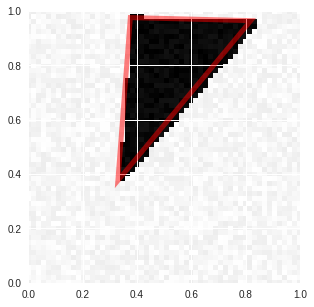

In [336]:
[X_train3, Y_train3] = generate_dataset_regression(300, 20)
visualize_prediction(X_train3[0], Y_train3[0])

In [477]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
#model.add(Conv2D(16, (3, 3), activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.2))
#model.add(Conv2D(8, (3, 3), activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(12,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(6))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='mean_absolute_error',optimizer=adam)

model.fit(X_train3.reshape(X_train3.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), Y_train3, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 10s 32ms/step - loss: 0.3062
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2440
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2084
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1949
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1765
Epoch 6/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1672
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1548
Epoch 8/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1416
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1318
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1246
Epoch 11/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1135
Epoch 12/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1081
Epoch 13/20
300/300 [==

In [462]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_490 (Conv2D)          (None, 68, 68, 16)        416       
_________________________________________________________________
flatten_91 (Flatten)         (None, 73984)             0         
_________________________________________________________________
dense_128 (Dense)            (None, 6)                 443910    
Total params: 444,326
Trainable params: 444,326
Non-trainable params: 0
_________________________________________________________________


In [356]:
[X_test3, Y_test3] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


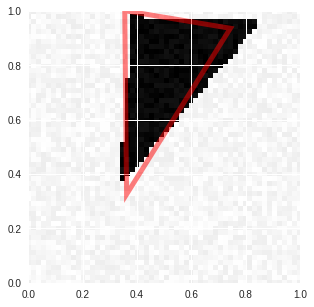

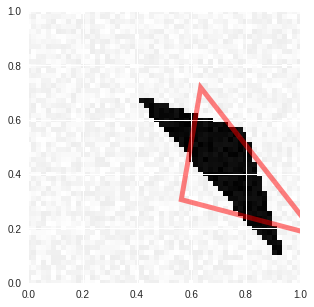

array([0.77639342, 0.5454629 , 0.39686117, 0.68093838, 0.90700812,
       0.09480827])

In [478]:
visualize_prediction(X_train3[0], model.predict(X_train3[0].reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)))
visualize_prediction(X_test3[5], model.predict(X_test3[5].reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)))
Y_test3[5]

In [479]:
eval = model.evaluate(X_test3.reshape(X_test3.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), Y_test3)
print('{} : {}'.format(model.metrics_names[0],eval))

300/300 [==============================] - 4s 14ms/step
loss : 0.2390589251120885


Our model suffers from overfitting. We tried to use dropout but it didn't improve the performances.

# Image denoising

We change the generation functions in order to produce pairs of images with a noise-free image and a noisy version of this image. The noisy is of random amplitude, bounded by a parameter we choose when creating the datasets.

In [0]:
def generate_rectangles(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_drawings(figsize, U, V, noise),generate_drawings(figsize, U, V, 0)]


def generate_disks(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_drawings(figsize, U, V, noise),generate_drawings(figsize, U, V, 0)]

def generate_triangles(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_drawings(figsize, U, V, noise)
    imdata2 = generate_drawings(figsize, U, V, 0)
    return [imdata, imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_noise(nb_samples, noise=20, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],Y[i]] = generate_rectangles(noise, free_location)
        elif category == 1: 
            [X[i],Y[i]] = generate_disks(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_triangles(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y  / 255
    return [X, Y]

def visualize(x):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    plt.show()
    
def generate_drawings(figsize, U, V, noise_max=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise_max * np.random.random_sample() * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

We test the image pairs generation:

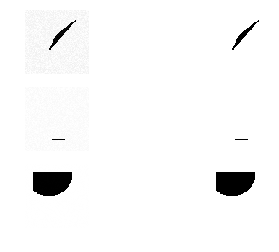

In [343]:
[im1,im2] = generate_rectangles(10, True)
[im3,im4] = generate_disks(10,True)
[im5,im6,v] = generate_triangles(20, True)

im = [im1,im2,im3,im4,im5,im6]

fig, axs = plt.subplots(3, 2)
for i in range(3):
    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,0].imshow(im[2*i-2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    axs[i,1].imshow(im[2*i-1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [350]:
[X_train4, Y_train4] = generate_dataset_classification_noise(300, 20 , True)
[X_test4, Y_test4] = generate_dataset_classification_noise(300, 20 , True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We use an hourglass network to perform the denoising task.

In [445]:
inputs = Input(shape=(72,72,1))

conv1 = Conv2D(64, 3, activation = 'relu',padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 3, activation = 'relu',padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, 3, activation = 'relu',padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

up4 = UpSampling2D(size = (2,2))(pool3)
up_conv4 = Conv2D(64, 3, activation = 'relu',padding='same')(up4)
merge4 = concatenate([conv3,up_conv4], axis=-1)

up5 = UpSampling2D(size = (2,2))(merge4)
up_conv5 = Conv2D(64, 3, activation = 'relu',padding='same')(up5)
merge5 = concatenate([conv2,up_conv5], axis=-1)

up6 = UpSampling2D(size = (2,2))(merge5)
up_conv6 = Conv2D(64, 3, activation = 'relu',padding='same')(up6)
merge6 = concatenate([conv1,up_conv6], axis=-1)

conv7 = Conv2D(1, 1, activation = 'sigmoid')(merge6)
model = Model(input = inputs, output = conv7)
model.compile(optimizer = 'adam',
loss = 'mean_squared_error')

model.summary()

model.fit(X_train4.reshape(X_train3.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), Y_train4.reshape(X_train3.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), epochs=10, batch_size=32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_475 (Conv2D)             (None, 72, 72, 64)   640         input_43[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_227 (MaxPooling2D (None, 36, 36, 64)   0           conv2d_475[0][0]                 
__________________________________________________________________________________________________
conv2d_476 (Conv2D)             (None, 36, 36, 64)   36928       max_pooling2d_227[0][0]          
__________________________________________________________________________________________________
max_poolin

Here are results of the network application on test images. The noisy image is at the left, the noise-free image is at the right and the result is located at the center.

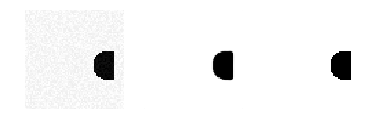

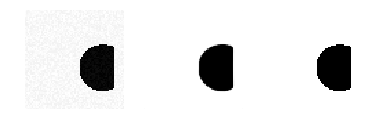

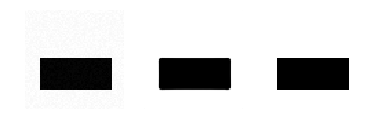

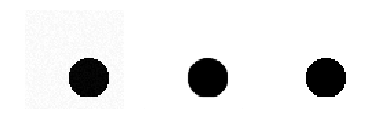

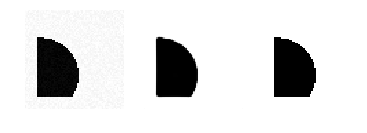

In [351]:
for j in range(5):
    fig, axs = plt.subplots(1, 3)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[0].imshow(X_test4[j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    axs[1].imshow(model.predict(X_test4[j].reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)).reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    axs[2].imshow(Y_test4[j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

Here we compute the loss on the test set.

In [347]:
val = model.evaluate(X_test4.reshape(X_test4.shape[0],IMAGE_SIZE,IMAGE_SIZE,1), Y_test4.reshape(X_test4.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))
print('{} : {}'.format(model.metrics_names[0],eval))

300/300 [==============================] - 10s 33ms/step
loss : 0.08489368508259455
